## 1. Library Import

In [399]:
!pip install eli5==0.13.0
!pip install geopy

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [400]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [401]:
train_path = '../train.csv'
test_path  = '../test.csv'
interest_path  = '../interest_rate.csv'
unsold_path  = '../unsold.csv'
rateindex_path  = '../rateindex.csv'

dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
interest_rate = pd.read_csv(interest_path)
unsold = pd.read_csv(unsold_path)
rateindex = pd.read_csv(rateindex_path)

In [402]:
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [403]:
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column 제외

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [404]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [405]:
dt['단지소개기존clob'][dt['단지소개기존clob'] > 0]

12         2888.0
13         2888.0
14         2888.0
15         2888.0
16         2888.0
            ...  
1118779     397.0
1118780     397.0
1118781     397.0
1118782     397.0
1118783      93.0
Name: 단지소개기존clob, Length: 68582, dtype: float64

In [406]:
dt['거래유형'][dt['거래유형'] != '-'].value_counts()

중개거래    29271
직거래      3100
Name: 거래유형, dtype: int64

In [407]:
dt_test['거래유형'][dt_test['거래유형'] != '-'].value_counts()

중개거래    8852
직거래      420
Name: 거래유형, dtype: int64

In [408]:
#dt = dt[dt['아파트명'].isin(dt_test['아파트명'])]
#dt = dt[dt['도로명'].isin(dt_test['도로명'])]
#dt = dt[dt['번지'].isin(dt_test['번지'])]

dt['등기신청일자'] = pd.to_numeric(dt['등기신청일자'], errors='coerce').astype('Int64')
dt['등기신청일자'] = dt['등기신청일자'].apply(lambda x: 1 if pd.notnull(x) else 0)
dt['해제사유발생일'] = dt['해제사유발생일'].apply(lambda x: 1 if pd.notnull(x) else 0)
dt = dt[(dt['등기신청일자'] != 1) & (dt['해제사유발생일'] != 1)]

## 3. Data Preprocessing

- 모델링 전 데이터 내 결측치, 이상치 등을 제거
- 범주형과 연속형 변수 등 확인

In [409]:
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])  

In [410]:
concat['is_test'].value_counts()  

0    1097924
1       9272
Name: is_test, dtype: int64

In [411]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [412]:
##### 결측치 해소 구간 #####

# '아파트명'이 '힐스테이트 서초 젠트리스'인 행의 '번지', '본번', '부번' 업데이트
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '번지'] = '557'
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '본번'] = '557'
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '부번'] = '0'

# '아파트명'이 '서초포레스타2단지'인 행의 '번지', '본번', '부번' 업데이트
concat.loc[concat['아파트명'] == '서초포레스타2단지', '번지'] = '384'
concat.loc[concat['아파트명'] == '서초포레스타2단지', '본번'] = '384'
concat.loc[concat['아파트명'] == '서초포레스타2단지', '부번'] = '0'

# 도로명을 기준으로 그룹화하고, 각 그룹 내에서 '아파트명'의 결측치를 채웁니다.
concat['아파트명'] = concat.groupby('도로명')['아파트명'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))



# 아파트명 직접 보간
concat.loc[concat['도로명'] == '천호대로77다길 11-6', '아파트명'] = '해오름아파트'
concat.loc[concat['도로명'] == '동호로11마길 20-8', '아파트명'] = '성민아트'
concat.loc[concat['도로명'] == '여의대방로62길 24', '아파트명'] = '효성아파트'
concat.loc[concat['도로명'] == '국사봉1길 18', '아파트명'] = '상진빌딩'
concat.loc[concat['도로명'] == '동호로11바길 30-8', '아파트명'] = '석종아파트'
concat.loc[concat['도로명'] == '신수로 89', '아파트명'] = '신수동 자이언트 아파트'
concat.loc[concat['도로명'] == '양재대로71길 2-11', '아파트명'] = '올림픽아트빌'
concat.loc[concat['도로명'] == '청계천로 295', '아파트명'] = '동대문신발상가'
concat.loc[concat['도로명'] == '대학로7길 15-4', '아파트명'] = '연건동아파트'
concat.loc[concat['도로명'] == '강남대로27길 7-14', '아파트명'] = '한일인텔빌라'
concat.loc[concat['도로명'] == '명륜2길 9-14', '아파트명'] = '명륜2길 9-14'
concat.loc[concat['도로명'] == '동호로5길 12', '아파트명'] = '다다유크레스'
concat.loc[concat['도로명'] == '증산로23길 8-8', '아파트명'] = '우일아파트'
concat.loc[concat['도로명'] == '낙산성곽동길 35-1', '아파트명'] = '낙산성곽동길 35-1'
concat.loc[concat['도로명'] == '서리풀길 14', '아파트명'] = 'callia vill'
concat.loc[concat['도로명'] == '효령로 200', '아파트명'] = '효령로 200'
concat.loc[concat['도로명'] == '화곡로 176-5', '아파트명'] = '화곡로 176-5'
concat.loc[concat['도로명'] == '광나루로12길 5', '아파트명'] = '광나루로12길 5'
concat.loc[concat['도로명'] == '개운사길 83-15', '아파트명'] = '개운사길 83-15'
concat.loc[concat['도로명'] == '도곡로93길 23', '아파트명'] = '대치 르엘'
concat.loc[concat['도로명'] == '까치산로14길 26-13', '아파트명'] = '힐탑아파트'
concat.loc[concat['도로명'] == '양천로 677', '아파트명'] = '염창하이츠빌딩'
concat.loc[concat['도로명'] == '천호대로118길 10', '아파트명'] = '천호대로118길 10'
concat.loc[concat['도로명'] == '난계로15길 36-6', '아파트명'] = '난계로15길 36-6'
concat.loc[concat['도로명'] == '난계로15길 36-8', '아파트명'] = '난계로15길 36-8'

concat.loc[concat['도로명'] == '이문로35아길 16', '도로명'] = '이문로16길 35'
concat.loc[concat['도로명'] == '이문로16길 35', '아파트명'] = '이문로16길 35'

concat.loc[concat['도로명'] == '마조로1길 45', '아파트명'] = '아파트'
concat.loc[concat['도로명'] == '성지3길 7', '아파트명'] = '성지3길 7'

In [413]:
concat['도로명']

0           언주로 3
1           언주로 3
2           언주로 3
3           언주로 3
4           언주로 3
          ...    
9267    신내역로1길 85
9268    신내역로1길 85
9269    신내역로1길 85
9270    신내역로1길 85
9271    신내역로1길 85
Name: 도로명, Length: 1107196, dtype: object

In [414]:
# 이상치 확인
display(concat['등기신청일자'].value_counts())

0           1097924
               7364
20230915        146
20230920        107
20230831        105
             ...   
20230712          4
20230705          2
20230707          2
20230703          1
20230704          1
Name: 등기신청일자, Length: 61, dtype: int64

In [415]:
display(concat['거래유형'].value_counts())

-       1081973
중개거래      22858
직거래        2365
Name: 거래유형, dtype: int64

In [416]:
display(concat['중개사소재지'].value_counts())

-                    1084366
서울 노원구                  1590
서울 강남구                  1457
서울 송파구                  1299
서울 서초구                  1114
                      ...   
경기 평택시, 서울 동작구             1
경기 안산단원구, 서울 동대문구          1
경기 의왕시, 서울 서초구             1
경기 구리시, 서울 서초구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 593, dtype: int64

In [417]:
# 결측치 처리
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [418]:
# 결측치 확인
concat.isnull().sum()

시군구                             0
번지                              0
본번                              0
부번                              0
아파트명                         1763
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                      9060
등기신청일자                       7364
거래유형                      1081973
중개사소재지                    1084366
k-단지분류(아파트,주상복합등등)         862044
k-전화번호                     861625
k-팩스번호                     864059
단지소개기존clob                1039232
k-세대타입(분양형태)               860906
k-관리방식                     860906
k-복도유형                     861226
k-난방방식                     860906
k-전체동수                     861980
k-전체세대수                    860906
k-건설사(시공사)                 862405
k-시행사                      862602
k-사용검사일-사용승인일              861040
k-연면적                      860906
k-주거전용면적      

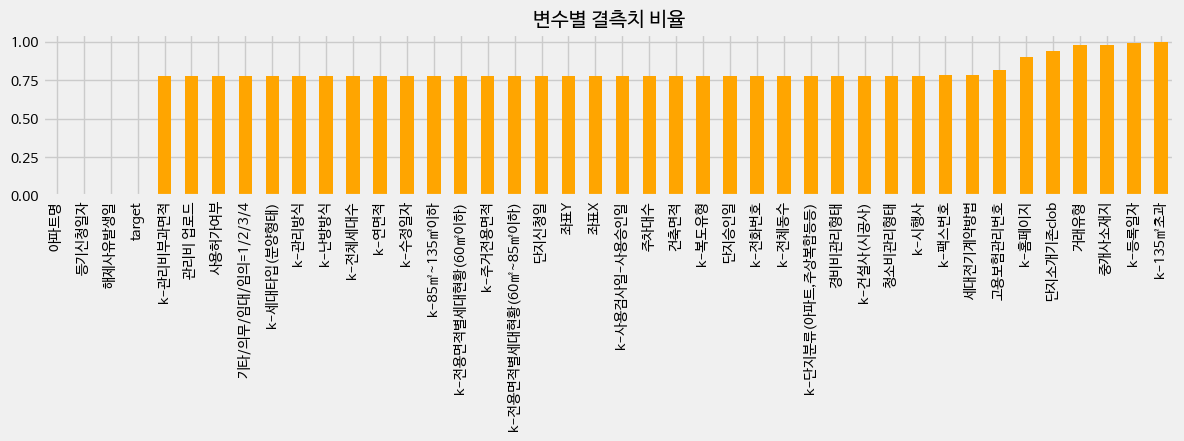

In [419]:
# 변수별 결측치 비율 확인
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지, 삭제

In [420]:
# Null값이 100만개 이상인 칼럼 삭체
print('결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
결측치가 100만개 이상인 변수들 : ['거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-등록일자']


In [421]:
# 결측치 100만개 이하인 변수들만 골라 새로운 concat_select로 저장
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [422]:
concat_select.isnull().sum()

시군구                            0
번지                             0
본번                             0
부번                             0
아파트명                        1763
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
해제사유발생일                     9060
등기신청일자                      7364
k-단지분류(아파트,주상복합등등)        862044
k-전화번호                    861625
k-팩스번호                    864059
k-세대타입(분양형태)              860906
k-관리방식                    860906
k-복도유형                    861226
k-난방방식                    860906
k-전체동수                    861980
k-전체세대수                   860906
k-건설사(시공사)                862405
k-시행사                     862602
k-사용검사일-사용승인일             861040
k-연면적                     860906
k-주거전용면적                  860951
k-관리비부과면적                 860906
k-전용면적별세대현황(60㎡이하)        860951
k-전용면적별세대현황(60㎡~85㎡이하)    860951
k-85㎡~135㎡

In [423]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107196 entries, 0 to 9271
Data columns (total 48 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1107196 non-null  object 
 1   번지                      1107196 non-null  object 
 2   본번                      1107196 non-null  object 
 3   부번                      1107196 non-null  object 
 4   아파트명                    1105433 non-null  object 
 5   전용면적                    1107196 non-null  float64
 6   계약년월                    1107196 non-null  int64  
 7   계약일                     1107196 non-null  int64  
 8   층                       1107196 non-null  int64  
 9   건축년도                    1107196 non-null  int64  
 10  도로명                     1107196 non-null  object 
 11  해제사유발생일                 1098136 non-null  float64
 12  등기신청일자                  1099832 non-null  object 
 13  k-단지분류(아파트,주상복합등등)      245152 non-null   object 
 14  k-전화번

In [424]:
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [425]:
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [426]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [427]:
concat_select.isnull().sum()      

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
해제사유발생일                   0
등기신청일자                    0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-홈페이지                    0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법            

### 3.2. 이상치 처리

In [428]:
print(concat_select.shape)

(1107196, 48)


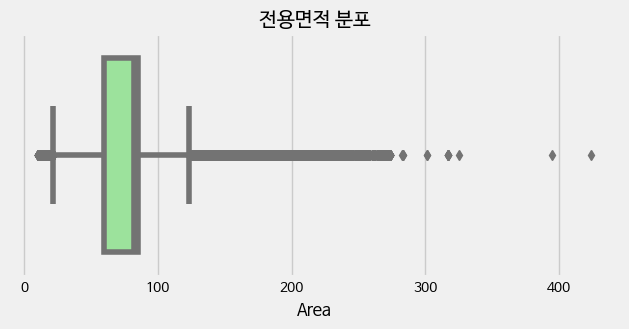

In [429]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

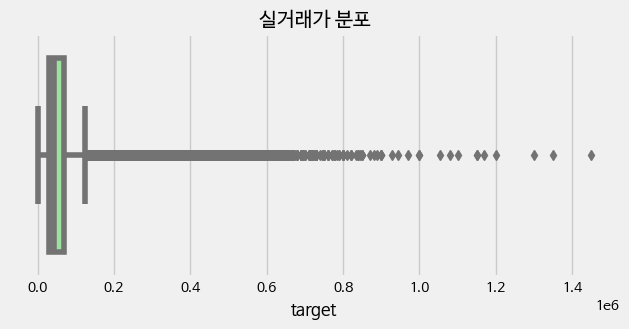

In [430]:
# target 분포
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = 'target', color='lightgreen')
plt.title('실거래가 분포')
plt.xlabel('target')
plt.show()

In [431]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [432]:
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [433]:
print(concat_select.shape)

(1020078, 48)


In [434]:
concat_select['is_test'].value_counts()   

0    1010806
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering

In [435]:
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

concat_select['계약년'] = concat_select['계약년'].astype('int')
concat_select['계약월'] = concat_select['계약월'].astype('int')

In [436]:
interest_rate[['계약년', '계약월']] = interest_rate[['계약년', '계약월']].astype('int')
interest_rate = interest_rate.drop(labels=['Unnamed: 15','Unnamed: 16'], axis = 1)
interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   계약년          204 non-null    int64  
 1   계약월          204 non-null    int64  
 2   기준금리         204 non-null    float64
 3   실질금리_주담대     204 non-null    float64
 4   실질금리_디딤돌     204 non-null    float64
 5   실질금리_디딤돌생최   204 non-null    float64
 6   총지수          204 non-null    float64
 7   생활물가         204 non-null    float64
 8   신선식품지수       204 non-null    float64
 9   식료품및에너지제외지수  204 non-null    float64
 10  농산물및석유류제외지수  204 non-null    float64
 11  인허가실적_수도권    204 non-null    int64  
 12  인허가실적_서울     204 non-null    int64  
 13  인허가실적_경기     204 non-null    int64  
 14  인허가실적_인천     204 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 24.0 KB


In [437]:
tmp = concat_select.copy()

tmp = pd.merge(tmp, unsold, on=['계약년', '계약월'], how='left')


In [438]:
rateindex = rateindex.iloc[:, :4]
rateindex.columns

Index(['계약년', '계약월', '매매전세비율', '매매거래활발지수'], dtype='object')

In [439]:
interest_rate

,계약년,계약월,기준금리,실질금리_주담대,실질금리_디딤돌,실질금리_디딤돌생최,총지수,생활물가,신선식품지수,식료품및에너지제외지수,농산물및석유류제외지수,인허가실적_수도권,인허가실적_서울,인허가실적_경기,인허가실적_인천
0,2023,12,3.5,4.59,3.3,3.0,0.0,-0.3,2.1,0.2,0.2,0,0,0,0
1,2023,11,3.5,4.72,3.3,3.0,-0.5,-0.8,-7.4,0.0,-0.1,369248,69328,243649,56271
2,2023,10,3.5,4.46,3.3,3.0,0.4,0.3,-0.8,0.3,0.4,333414,66428,218171,48815
3,2023,9,3.5,4.40,3.3,3.0,0.5,1.0,3.6,-0.1,0.2,314166,60116,207803,46247
4,2023,8,3.5,4.41,3.3,3.0,0.9,1.3,9.6,0.2,0.2,251741,58833,157849,35059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2007,5,4.5,6.17,0.0,0.0,0.1,0.2,-2.3,0.1,0.0,129365,25526,88492,15347
200,2007,4,4.5,6.13,0.0,0.0,0.4,0.6,-0.2,0.2,0.3,80239,19544,46316,14379
201,2007,3,4.5,6.20,0.0,0.0,0.6,1.0,-2.3,0.8,0.7,48571,13232,31452,3887
202,2007,2,4.5,6.18,0.0,0.0,0.7,0.8,5.8,0.5,0.4,27380,7300,19183,897


In [440]:
unsold

,계약년,계약월,서울_미분양,전국_미분양,강남구,강동구,강북구,강서구,관악구,광진구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,2023,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023,11,877,1754,0,275,127,115,0,38,...,0,0,0,0,0,28,0,0,3,0
2,2023,10,908,1816,0,276,125,127,0,38,...,0,0,0,0,0,29,0,0,3,0
3,2023,9,914,1828,0,212,148,151,0,38,...,0,0,0,0,0,32,0,0,3,0
4,2023,8,976,1952,0,212,201,170,0,3,...,0,0,0,0,0,35,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2007,5,704,1408,0,0,0,0,0,187,...,0,404,0,94,0,0,0,19,0,0
200,2007,4,685,1370,0,0,0,0,0,187,...,0,404,0,94,0,0,0,0,0,0
201,2007,3,687,1374,0,0,0,0,0,187,...,0,404,0,96,0,0,0,0,0,0
202,2007,2,590,1180,0,0,0,0,0,107,...,0,404,0,79,0,0,0,0,0,0


In [441]:
rateindex

,계약년,계약월,매매전세비율,매매거래활발지수
0,2023,6,50.956520,12.524229
1,2023,5,50.871169,8.096037
2,2023,4,50.826571,6.343467
3,2023,3,50.919858,5.185321
4,2023,2,51.234776,6.285631
...,...,...,...,...
193,2007,5,43.189000,4.478921
194,2007,4,43.149000,8.627288
195,2007,3,42.987000,6.618330
196,2007,2,42.823000,5.622157


In [442]:
tmp = pd.merge(tmp, rateindex, on=['계약년', '계약월'], how='left')
concat_select = pd.merge(tmp , interest_rate, on=['계약년', '계약월'], how='left')

In [443]:
concat_select['구_미분양'] = None

for index, gu_name in enumerate(concat_select['구']):
    concat_select.loc[index, '구_미분양'] = concat_select.loc[index, f'{gu_name}']

In [444]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동', '계약년', '계약월',
       '서울_미분양', '전국_미분양', '강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구',
       '금천구', '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구',
       '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구', '매매전세비율',
       '매매거래활발지수', '기준금리', '실질금리_주담대', '실질금리_디딤돌', '실질금리_디딤돌생최', '총지수', '생활물가',
       '신선식품지수', '식료품및에너지제외지수', '농산물및석유류제외지수', '인허가실적_수도권', '인허가실적_서울',
       '인허가실적_경기', '인허가실적_인천', '

In [445]:
concat_select['기준금리'].isnull().sum()

0

In [446]:
concat_select.isnull().sum()

번지           0
본번           0
부번           0
아파트명         0
전용면적         0
            ..
인허가실적_수도권    0
인허가실적_서울     0
인허가실적_경기     0
인허가실적_인천     0
구_미분양        0
Length: 93, dtype: int64

In [447]:
concat_select['매매거래활발지수']

0          17.693929
1          17.693929
2          17.693929
3          27.764117
4          27.764117
             ...    
1020073          NaN
1020074          NaN
1020075          NaN
1020076          NaN
1020077          NaN
Name: 매매거래활발지수, Length: 1020078, dtype: float64

In [448]:
concat_select['매매거래활발지수'] = concat_select['매매거래활발지수'].interpolate(method='linear', axis=0)

In [449]:
gu_col = ['강남구','강동구','강북구','강서구','관악구','광진구','구로구','금천구','노원구','도봉구','동대문구','동작구','마포구','서대문구','서초구','성동구','성북구','송파구','양천구','영등포구','용산구','은평구','종로구','중구','중랑구']

concat_select.drop(labels=gu_col,axis=1, inplace=True)

concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동', '계약년', '계약월',
       '서울_미분양', '전국_미분양', '매매전세비율', '매매거래활발지수', '기준금리', '실질금리_주담대',
       '실질금리_디딤돌', '실질금리_디딤돌생최', '총지수', '생활물가', '신선식품지수', '식료품및에너지제외지수',
       '농산물및석유류제외지수', '인허가실적_수도권', '인허가실적_서울', '인허가실적_경기', '인허가실적_인천',
       '구_미분양'],
      dtype='object')

In [450]:
concat_select['계약년'] = concat_select['계약년'].astype('str')
concat_select['계약월'] = concat_select['계약월'].astype('str')

- 강남/강북의 여부에 따라 파생변수 생성

In [451]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [452]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [453]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동', '계약년', '계약월',
       '서울_미분양', '전국_미분양', '매매전세비율', '매매거래활발지수', '기준금리', '실질금리_주담대',
       '실질금리_디딤돌', '실질금리_디딤돌생최', '총지수', '생활물가', '신선식품지수', '식료품및에너지제외지수',
       '농산물및석유류제외지수', '인허가실적_수도권', '인허가실적_서울', '인허가실적_경기', '인허가실적_인천', '구_미분양',
       '강남여부'],
      dtype='object')

- 신축/구축 여부, 건축년도에 따라 파생변수 생성

In [454]:
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.020078e+06
mean     1.998503e+03
std      9.067342e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.004000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [455]:
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [456]:
concat_select['강남여부'] = concat_select['강남여부'].astype('str')
concat_select['신축여부'] = concat_select['신축여부'].astype('str')
concat_select['구_미분양'] = concat_select['구_미분양'].astype('int')

In [457]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,해제사유발생일,...,신선식품지수,식료품및에너지제외지수,농산물및석유류제외지수,인허가실적_수도권,인허가실적_서울,인허가실적_경기,인허가실적_인천,구_미분양,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,0.0,...,3.7,0.2,0.2,1024634,349248,603491,71895,0,1,0


In [458]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-홈페이지', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동', '계약년', '계약월',
       '서울_미분양', '전국_미분양', '매매전세비율', '매매거래활발지수', '기준금리', '실질금리_주담대',
       '실질금리_디딤돌', '실질금리_디딤돌생최', '총지수', '생활물가', '신선식품지수', '식료품및에너지제외지수',
       '농산물및석유류제외지수', '인허가실적_수도권', '인허가실적_서울', '인허가실적_경기', '인허가실적_인천', '구_미분양',
       '강남여부', '신축여부'],
      dtype='object')

In [459]:
concat_select_cor = concat_select['총지수'].corr(concat['target'])
concat_select_cor

-0.05598212210533839

In [460]:
sel_col = ['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명','등기신청일자', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       '건축면적', '주차대수','좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동','서울_미분양', '전국_미분양', '매매전세비율', '매매거래활발지수', '기준금리', '실질금리_주담대',
       '실질금리_디딤돌', '실질금리_디딤돌생최', '총지수', '생활물가', '신선식품지수', '식료품및에너지제외지수',
       '농산물및석유류제외지수', '인허가실적_수도권', '인허가실적_서울', '인허가실적_경기', '인허가실적_인천', '구_미분양',
       '강남여부']

In [ ]:
'''
sel_col = ['계약년', '전용면적', '매매전세비율', '좌표X', '좌표Y', '건축년도', '구', '아파트명', '도로명', '번지',
       '부번', '본번', '건축면적', '동', '층', '구_미분양', '전국_미분양', '서울_미분양',
       '강남여부', '신축여부', 'k-시행사', '계약일', 'k-관리비부과면적', 'k-전체세대수',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-수정일자', '총지수',
       '실질금리_주담대', '주차대수', 'is_test', 'target']
'''

## 5. Model Training

In [ ]:
#select_col = ['계약년', '전용면적','좌표X','좌표Y', '건축년도','구','아파트명', '도로명','부번','건축면적', '주차대수', '동', '층', '구_미분양', '강남여부', '신축여부', 'k-시행사', '계약일', 'k-관리비부과면적', 'k-전체세대수','k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-수정일자', 'is_test', 'target']
#select_col = ['계약년', '전용면적', '아파트명', 'is_test', 'target'] # RMSE 24910
#select_col = ['계약년', '전용면적', '아파트명', '도로명', '구_미분양', '강남여부', '신축여부', 'is_test', 'target'] # RMSE 15083
#select_col = ['계약년', '전용면적', '아파트명', '도로명', '총지수', '실질금리_주담대','is_test', 'target'] # RMSE 14163
#select_col = ['계약년', '전용면적', '아파트명', '도로명', '구_미분양', '강남여부', '신축여부', '총지수', '실질금리_주담대', 'is_test', 'target'] # RMSE 12101 
#select_col = ['계약년', '전용면적','건축년도','구','아파트명', '도로명','부번','건축면적', '주차대수', '동', '층', '구_미분양', '강남여부', '신축여부', 'k-시행사', '계약일', 'k-관리비부과면적', 'k-전체세대수','k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-수정일자', '총지수', '실질금리_주담대', 'is_test', 'target'] # RMSE 8639

#select_col = ['계약년', '아파트명', 'is_test', 'target'] # RMSE 41842.896
#select_col = ['계약년', '아파트명', '도로명', '매매전세비율','매매거래활발지수','is_test', 'target'] # 21054.8909


select_col = ['계약년', '전용면적', '매매전세비율', '좌표X', '좌표Y', '건축년도','구','아파트명', '도로명','번지','부번','본번','건축면적', '주차대수', '동', '층', '구_미분양', '전국_미분양','서울_미분양','강남여부', '신축여부', 'k-시행사', '계약일', 'k-관리비부과면적', 'k-전체세대수','k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-수정일자', '총지수', '실질금리_주담대', 'is_test', 'target']

concat_select = concat_select.loc[:, select_col]

# train/test 분할
dt_train = concat_select.query('is_test==0')
dt_train = dt_train[dt_train['계약년'] > '2009']
#dt_train = dt_train[dt_train['계약년'] > '2017']

dt_test = concat_select.query('is_test==1')


# is_test drop
dt_train.drop(['is_test', '계약년'], axis = 1, inplace=True)
dt_test.drop(['is_test', '계약년'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(830961, 30) (9272, 30)


In [ ]:
dt_test.head(1)

,전용면적,매매전세비율,좌표X,좌표Y,건축년도,구,아파트명,도로명,번지,부번,...,k-시행사,계약일,k-관리비부과면적,k-전체세대수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-수정일자,총지수,실질금리_주담대,target
1010806,79.97,NaN,127.05721,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,26,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.1,4.42,13250.0


In [ ]:
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding

In [ ]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '매매전세비율', '좌표X', '좌표Y', '건축년도', '건축면적', '주차대수', '층', '구_미분양', '전국_미분양', '서울_미분양', '계약일', 'k-관리비부과면적', 'k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', '총지수', '실질금리_주담대', 'target']
범주형 변수: ['구', '아파트명', '도로명', '번지', '부번', '본번', '동', '강남여부', '신축여부', 'k-시행사', 'k-수정일자']


In [ ]:
dt_test['아파트명'].info()

<class 'pandas.core.series.Series'>
Int64Index: 9272 entries, 1010806 to 1020077
Series name: 아파트명
Non-Null Count  Dtype 
--------------  ----- 
9272 non-null   object
dtypes: object(1)
memory usage: 144.9+ KB


In [ ]:
dt_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830961 entries, 0 to 930089
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   전용면적                    830961 non-null  float64
 1   매매전세비율                  830961 non-null  float64
 2   좌표X                     830961 non-null  float64
 3   좌표Y                     830961 non-null  float64
 4   건축년도                    830961 non-null  int64  
 5   구                       830961 non-null  object 
 6   아파트명                    830961 non-null  object 
 7   도로명                     830961 non-null  object 
 8   번지                      830961 non-null  object 
 9   부번                      830961 non-null  object 
 10  본번                      830961 non-null  object 
 11  건축면적                    830961 non-null  float64
 12  주차대수                    830961 non-null  float64
 13  동                       830961 non-null  object 
 14  층                   

In [ ]:
print(dt_train.shape, dt_test.shape)

(830961, 30) (9272, 30)


In [ ]:
dt_train

,전용면적,매매전세비율,좌표X,좌표Y,건축년도,구,아파트명,도로명,번지,부번,...,k-시행사,계약일,k-관리비부과면적,k-전체세대수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-수정일자,총지수,실질금리_주담대,target
0,79.97,70.0590,127.057210,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,8,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.4,3.50,124000.0
1,79.97,70.0590,127.057210,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,22,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.4,3.50,123500.0
2,54.98,70.0590,127.057210,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,28,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.4,3.50,91500.0
3,79.97,69.3220,127.057210,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,3,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.4,3.52,130000.0
4,79.97,69.3220,127.057210,37.476763,1987,강남구,개포6차우성,언주로 3,658-1,1.0,...,모름,8,22637.0,270.0,20.0,250.0,2023-09-23 17:21:41.0,0.4,3.52,117000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930084,59.92,42.3169,127.015931,37.580983,2008,종로구,종로센트레빌,동망산길 47,2-1,1.0,...,숭인제4구역재정비사업조합,1,41883.0,416.0,180.0,164.0,2023-09-26 04:16:19.0,0.2,4.70,39400.0
930086,52.46,40.9792,127.000071,37.560706,1981,중구,묵정,서애로1길 34,11-67,67.0,...,묵정아파트 주택조합,18,6912.0,122.0,121.0,0.0,2023-09-26 04:36:29.0,0.2,5.75,19300.0
930087,52.46,40.9792,127.000071,37.560706,1981,중구,묵정,서애로1길 34,11-67,67.0,...,묵정아파트 주택조합,20,6912.0,122.0,121.0,0.0,2023-09-26 04:36:29.0,0.2,5.75,18900.0
930088,52.46,41.7825,127.000071,37.560706,1981,중구,묵정,서애로1길 34,11-67,67.0,...,묵정아파트 주택조합,11,6912.0,122.0,121.0,0.0,2023-09-26 04:36:29.0,0.1,4.78,21500.0


In [ ]:
# 범주형 변수 레이블인코딩
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 후처리를 위해 레이블인코더 저장

    # Test 데이터에만 존재하는 데이터 신규 클래스로 추가
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # ValueError발생 방지

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 11/11 [00:02<00:00,  4.40it/s]


In [ ]:
dt_train.head(1)       

,전용면적,매매전세비율,좌표X,좌표Y,건축년도,구,아파트명,도로명,번지,부번,...,k-시행사,계약일,k-관리비부과면적,k-전체세대수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-수정일자,총지수,실질금리_주담대,target
0,79.97,70.059,127.05721,37.476763,1987,0,290,5434,4256,2,...,206,8,22637.0,270.0,20.0,250.0,201,0.4,3.5,124000.0


In [ ]:
dt_test.head(1)    

,전용면적,매매전세비율,좌표X,좌표Y,건축년도,구,아파트명,도로명,번지,부번,...,k-시행사,계약일,k-관리비부과면적,k-전체세대수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-수정일자,총지수,실질금리_주담대,target
1010806,79.97,NaN,127.05721,37.476763,1987,0,290,5434,4256,2,...,206,26,22637.0,270.0,20.0,250.0,201,0.1,4.42,0


#### target incoding 시도

### 5.2. Model Training


In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]     

In [ ]:
# Target, 독립변수 분리
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

In [ ]:
# Hold out split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

##### timeseries split

In [ ]:
# 열 이름에서 특수 문자 및 공백을 언더스코어로 대체
dt_train.columns = [col.replace('-', '_').replace(',', '_').replace('=', '_').replace('/', '_').replace('㎡', '_').replace('~', '_').replace('(', '_').replace(')', '_') for col in dt_train.columns]


train_X, train_y = dt_train.drop(['target'], axis=1), dt_train['target']
print(train_X.shape, train_y.shape)

(830961, 29) (830961,)


In [ ]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830961 entries, 0 to 930089
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   전용면적                    830961 non-null  float64
 1   매매전세비율                  830961 non-null  float64
 2   좌표X                     830961 non-null  float64
 3   좌표Y                     830961 non-null  float64
 4   건축년도                    830961 non-null  int64  
 5   구                       830961 non-null  int64  
 6   아파트명                    830961 non-null  int64  
 7   도로명                     830961 non-null  int64  
 8   번지                      830961 non-null  int64  
 9   부번                      830961 non-null  int64  
 10  본번                      830961 non-null  int64  
 11  건축면적                    830961 non-null  float64
 12  주차대수                    830961 non-null  float64
 13  동                       830961 non-null  int64  
 14  층                   

In [ ]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
import lightgbm as lgb

rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_lgb_t = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [ ]:
models = []
scores = []
for model in [model_lgb_t]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)
    
#LGBMRegressor mean RMSLE: 15842.6846 - 15776 - 15082 - (16)14467 (10)14466

LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4298
[LightGBM] [Info] Number of data points in the train set: 75551, number of used features: 29
[LightGBM] [Info] Start training from score 62054.986857


LGBMRegressor Cross Validations...:  10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4650
[LightGBM] [Info] Number of data points in the train set: 151092, number of used features: 29
[LightGBM] [Info] Start training from score 62974.535310


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:02<00:12,  1.52s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4703
[LightGBM] [Info] Number of data points in the train set: 226633, number of used features: 29
[LightGBM] [Info] Start training from score 68650.656193


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:05<00:12,  1.76s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4750
[LightGBM] [Info] Number of data points in the train set: 302174, number of used features: 29
[LightGBM] [Info] Start training from score 71296.809583


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:07<00:12,  2.06s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4789
[LightGBM] [Info] Number of data points in the train set: 377715, number of used features: 29
[LightGBM] [Info] Start training from score 68440.060678


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:10<00:11,  2.34s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 453256, number of used features: 29
[LightGBM] [Info] Start training from score 65629.490729


LGBMRegressor Cross Validations...:  60%|██████    | 6/10 [00:13<00:10,  2.61s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4891
[LightGBM] [Info] Number of data points in the train set: 528797, number of used features: 29
[LightGBM] [Info] Start training from score 63519.243640


LGBMRegressor Cross Validations...:  70%|███████   | 7/10 [00:17<00:08,  2.96s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4907
[LightGBM] [Info] Number of data points in the train set: 604338, number of used features: 29
[LightGBM] [Info] Start training from score 60861.958482


LGBMRegressor Cross Validations...:  80%|████████  | 8/10 [00:21<00:06,  3.26s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4986
[LightGBM] [Info] Number of data points in the train set: 679879, number of used features: 29
[LightGBM] [Info] Start training from score 58718.410430


LGBMRegressor Cross Validations...:  90%|█████████ | 9/10 [00:25<00:03,  3.56s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5066
[LightGBM] [Info] Number of data points in the train set: 755420, number of used features: 29
[LightGBM] [Info] Start training from score 57044.377683


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
1 FOLDS: LGBMRegressor RMSLE: 42171.3156
2 FOLDS: LGBMRegressor RMSLE: 21451.4525
3 FOLDS: LGBMRegressor RMSLE: 15214.3873
4 FOLDS: LGBMRegressor RMSLE: 11615.2511
5 FOLDS: LGBMRegressor RMSLE: 9359.5292
6 FOLDS: LGBMRegressor RMSLE: 10694.6493
7 FOLDS: LGBMRegressor RMSLE: 7737.3066
8 FOLDS: LGBMRegressor RMSLE: 15748.6647
9 FOLDS: LGBMRegressor RMSLE: 7957.1738
10 FOLDS: LGBMRegressor RMSLE: 7315.2141

LGBMRegressor mean RMSLE: 14926.4944


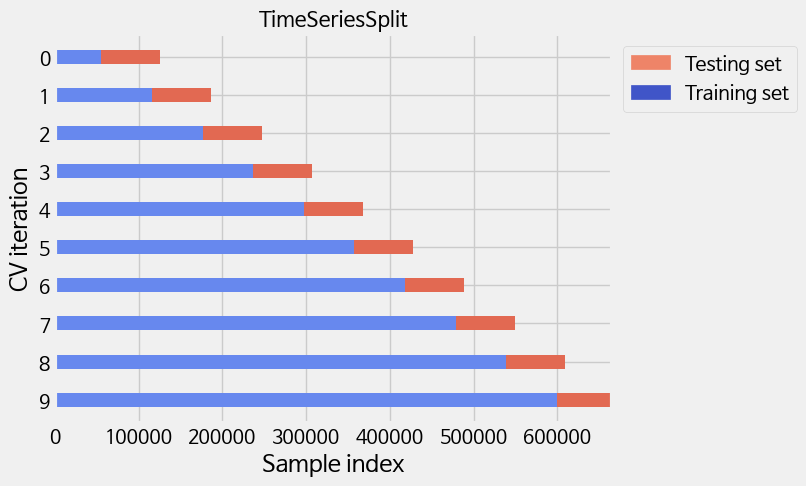

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))


tscv = TimeSeriesSplit(n_splits=10)

plot_cv_indices(tscv, X_train, n_splits=10)

In [ ]:
# RandomForestRegressor
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [ ]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}') #5885.7106

RMSE test: 6552.216360523575


In [ ]:
import lightgbm as lgb

# 열 이름에서 특수 문자 및 공백 언더스코어로 대체
X_train.columns = [col.replace('-', '_').replace(',', '_').replace('=', '_').replace('/', '_').replace('㎡', '_').replace('~', '_').replace('(', '_').replace(')', '_') for col in X_train.columns]
X_val.columns = [col.replace('-', '_').replace(',', '_').replace('=', '_').replace('/', '_').replace('㎡', '_').replace('~', '_').replace('(', '_').replace(')', '_') for col in X_val.columns]

# 모델 생성 및 학습
model_lgb = lgb.LGBMRegressor(n_estimators=500, criterion='squared_error', objective='regression', max_depth=9, min_child_weight=5, n_jobs=-1)
model_lgb.fit(X_train, y_train)

# 예측
pred_lgb = model_lgb.predict(X_val)

# RMSE 계산 및 출력
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_lgb))}') # 6945.918 # 11637 # select_col 13649 - 12535 - 12371 - 12019 - 11412
# 모든 변수 투입 7357.1148

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5116
[LightGBM] [Info] Number of data points in the train set: 664768, number of used features: 29
[LightGBM] [Info] Start training from score 55545.183741
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE test: 7088.8080335442


In [ ]:
dt_train.columns

Index(['전용면적', '매매전세비율', '좌표X', '좌표Y', '건축년도', '구', '아파트명', '도로명', '번지', '부번',
       '본번', '건축면적', '주차대수', '동', '층', '구_미분양', '전국_미분양', '서울_미분양', '강남여부',
       '신축여부', 'k_시행사', '계약일', 'k_관리비부과면적', 'k_전체세대수', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_수정일자', '총지수', '실질금리_주담대', 'target'],
      dtype='object')

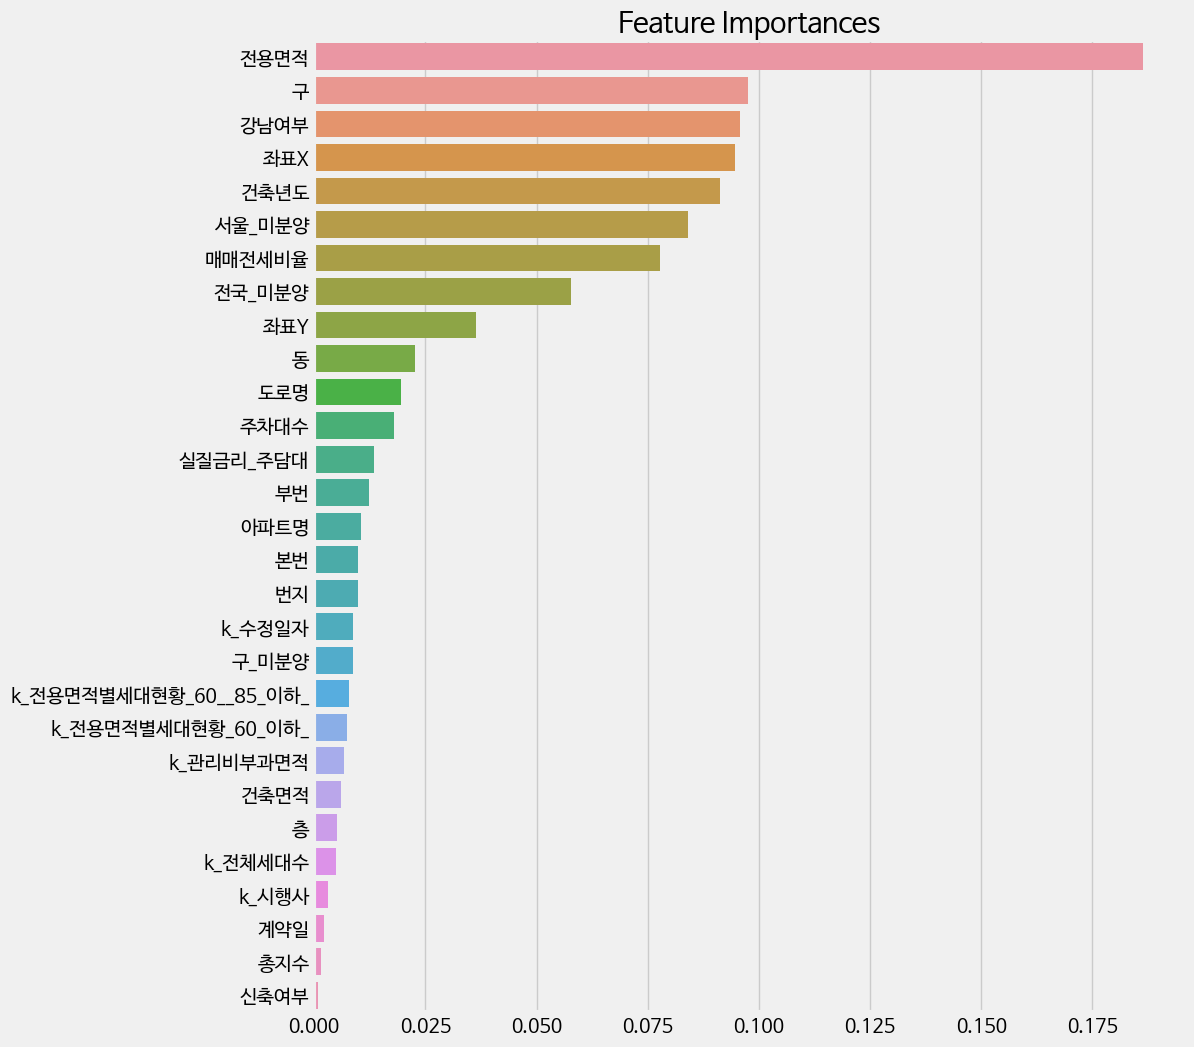

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# 학습된 모델 저장
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model_lgb_t, f)

In [ ]:
X_val.columns

Index(['전용면적', '매매전세비율', '좌표X', '좌표Y', '건축년도', '구', '아파트명', '도로명', '번지', '부번',
       '본번', '건축면적', '주차대수', '동', '층', '구_미분양', '전국_미분양', '서울_미분양', '강남여부',
       '신축여부', 'k_시행사', '계약일', 'k_관리비부과면적', 'k_전체세대수', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_수정일자', '총지수', '실질금리_주담대'],
      dtype='object')

### 5.3. Feature selection

In [ ]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3)
perm = perm.fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

### 5.4. Valid prediction 분석

In [ ]:
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error 계산 함수
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순

In [ ]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,해제사유발생일,...,서울_미분양,전국_미분양,매매전세비율,매매거래활발지수,구_미분양,강남여부,신축여부,target,pred,error
190950,4075,1071,255,4684,91.68,27,3,2017,2164,0.0,...,719,1438,54.678929,3.587079,0,1,1,117562.0,306000.0,3.550888e+10
196898,4804,1220,0,2034,106.26,13,3,1973,4903,0.0,...,55,110,54.552000,7.683006,0,1,0,530000.0,378600.0,2.292196e+10
188984,3654,969,0,3826,107.99,25,-2,2016,2945,0.0,...,1144,2288,50.871169,8.096037,0,0,1,290000.0,139940.0,2.251800e+10
232813,1030,381,2,2784,81.22,29,2,2017,8021,0.0,...,59,118,55.462200,14.108997,0,1,1,104000.0,251000.0,2.160900e+10
197546,725,259,35,1512,83.60,2,21,2016,4204,0.0,...,55,110,54.552000,7.683006,0,1,1,294000.0,163000.0,1.716100e+10


- 예측을 잘 하지 못한 top 100개 vs 예측을 잘한 top 100개 비교

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 레이블인코딩 된 변수 복원
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # categorical_columns_v2 범주형 변수 리스트 사용
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # categorical_columns_v2 범주형 변수 리스트 사용
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

,아파트명,도로명,매매전세비율,매매거래활발지수,target,pred,error
197393,반포주공1단지,신반포로 45,54.586033,1.548079,287000.0,544416.666667,6.626334e+10


,아파트명,도로명,매매전세비율,매매거래활발지수,target,pred,error
287368,대상타운현대,마들로 616,56.0397,25.031809,67000.0,67039.166667,1534.027778


- 이제 분포를 비교해보도록 하겠습니다.

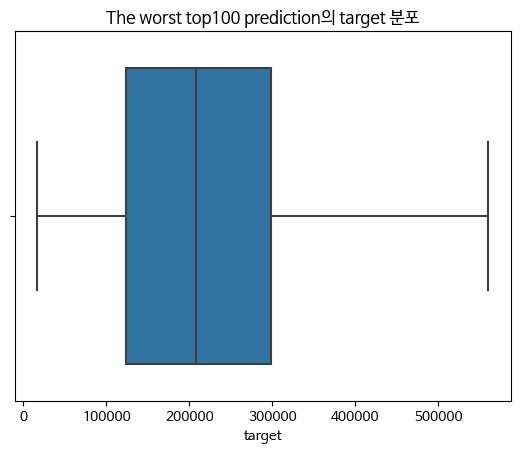

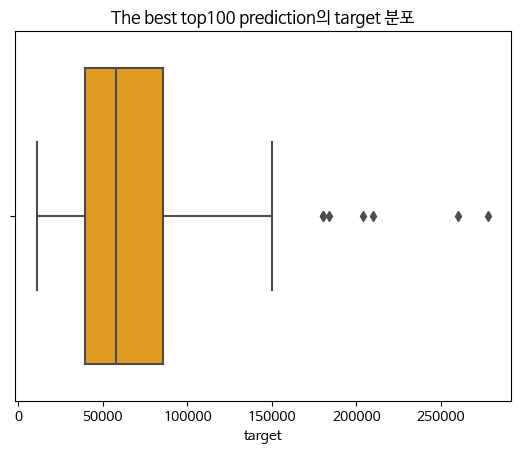

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 더 높은 가격으로 나타남

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference

,전용면적,아파트명,도로명,구_미분양,강남여부,신축여부,총지수,실질금리_주담대,target
746371,79.9700,121,1613,0,1,0,0.1,4.42,0
746372,108.2017,1974,2424,0,1,1,0.9,4.41,0


In [ ]:
# 저장된 모델
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset inference
real_test_pred = model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 29.9 ms


In [ ]:
real_test_pred        

array([152966.05420698, 280035.96346558, 214022.36535431, ...,
        85319.00230916,  79730.80945722,  81764.46512678])

## 7. Output File Save

In [ ]:
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)